### Setup

In [9]:
import os
import sys
import datetime
import calendar
import itertools
import math
import time

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model, unitroot
import warnings
warnings.warn = lambda *a, **kw: False
warnings.filterwarnings("ignore")

sys.path.append("..") # Adds higher directory to python modules path for importing from src dir
from src.datasets import NyseStocksDataset, NyseSecuritiesDataset, NyseFundamentalsDataset
import src.econometric_utils as eco
import src.regression_utils as regr
import src.plot_utils as plot
import src.math_utils as math_utils

import networkx as nx
# https://networkx.github.io/documentation/stable/tutorial.html
import visJS2jupyter
import visJS2jupyter.visJS_module as visJS_module
# http://compbio.ucsd.edu/bringing-interactivity-network-visualization-jupyter-notebooks-visjs2jupyter/


get_month = lambda i: datetime.date(2000, int(i), 1).strftime('%B')
get_weekday = lambda i: calendar.day_name[int(i)]
split = lambda x: (x.iloc[:600], x.iloc[600:])  # train: 2010-01-05 until 2012-05-21, val: 2012-05-21 until 2012-12-31

TRAIN_FRAME = pd.to_datetime('2010-01-05'), pd.to_datetime('2012-05-21')
VAL_FRAME = pd.to_datetime('2012-05-22'), pd.to_datetime('2012-12-31')

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 213 ms


In [2]:
stocks = NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices-split-adjusted.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close'], load=True, look_back=1)
securities = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv', load=True)
fundamentals = NyseFundamentalsDataset(file_path='../data/nyse/fundamentals.csv', load=True)


time: 7.15 s


In [3]:
gspc = stocks.load_gspc().set_index('date')[['gspc_open', 'gspc_close']].rename(lambda x: x.replace('gspc_', ''), axis=1)
gspc = eco.add_movements(gspc)

vix = stocks.load_vix().set_index('date')[['vix_open', 'vix_close']].rename(lambda x: x.replace('vix_', ''), axis=1)
vix = eco.add_movements(vix)

prices = stocks.enhance_features(stocks.prices.copy())
comp_metas, train_comp_prices, val_comp_prices = [], [], []
comp_grouped = prices.groupby(prices.symbol, sort=False)
for sym, p in tqdm(comp_grouped):
    if not stocks.is_company_available(sym):
        continue
    train, val = split(eco.add_movements(p).drop(columns=['symbol', 'movement']).set_index('date'))
    assert train.index.min() == TRAIN_FRAME[0] and train.index.max() == TRAIN_FRAME[1], f'Shape not matching for {sym}'
    assert val.index.min() == VAL_FRAME[0] and val.index.max() == VAL_FRAME[1], f'Shape not matching for {sym}'
    train_comp_prices.append(train)
    val_comp_prices.append(val)
    comp_metas.append({'symbol': sym, 'industry': securities.get_industry(sym), 'name': securities.get_company_name(sym)})

comp_metas = pd.DataFrame(comp_metas)


time: 1min 43s


### Select Industry

In [4]:
def get_industry(ind_name, val=False):
    indizes = comp_metas.index[comp_metas.industry == ind_name]
    for i in indizes:
        _, name, symbol = comp_metas.iloc[i]
        if val:
            yield symbol, name, val_comp_prices[i]
        else:
            yield symbol, name, train_comp_prices[i]

all_industries = comp_metas.industry.unique()
print('Industries:', ', '.join(all_industries))

Industries: Health Care, Industrials, Consumer Discretionary, Information Technology, Consumer Staples, Utilities, Financials, Materials, Real Estate, Energy, Telecommunications Services
time: 181 ms


In [5]:
# Calculate movements per industry to normalize stock prices
ind_means = pd.DataFrame([pd.DataFrame([p.boxcox for _, _, p in get_industry(i)]).mean() for i in all_industries], index=all_industries).T
# (ind_means.T - gspc.boxcox[ind_means.index]).T.corr()

pd.Series([len(list(get_industry(x))) for x in all_industries], index=all_industries)

Health Care                    54
Industrials                    63
Consumer Discretionary         77
Information Technology         63
Consumer Staples               34
Utilities                      28
Financials                     58
Materials                      23
Real Estate                    29
Energy                         33
Telecommunications Services     5
dtype: int64

time: 531 ms


In [6]:
# e.g. greatest energy companies: XOM, CHK
industry_name = 'Energy'  # 'Information Technology'
industry = list(get_industry(industry_name))
industry_val = list(get_industry(industry_name, val=True))
greatest_comp = np.argmax([(p.volume.max()) for _, _, p in industry])
(symbol, name, price), val_price = industry[greatest_comp], industry_val[greatest_comp][2]

time: 184 ms


Shapiro test (null=normal): p value = 0.0000
Shapiro test (null=normal): p value = 0.0000
Shapiro test (null=normal): p value = 0.0000

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 1.0000
>Kruskal-Wallis (null = equal): p value = 0.9074
>Mann-Whitney (null = equal): p value = 0.4537

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 0.9988
>Kruskal-Wallis (null = equal): p value = 0.7601
>Mann-Whitney (null = equal): p value = 0.3801


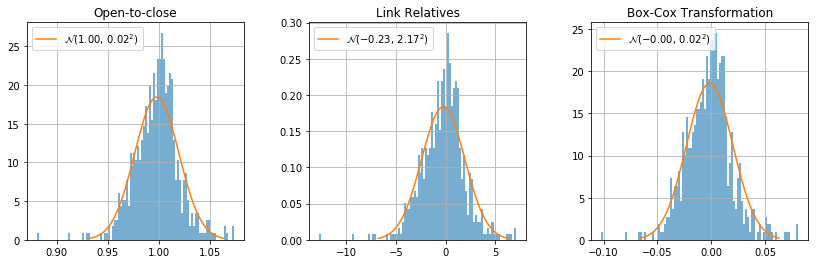

time: 1.88 s


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot.compare_with_normal(price.otc, 'Open-to-close', ax=axes[0])
plot.compare_with_normal(price.lret, 'Link Relatives', ax=axes[1])
plot.compare_with_normal(price.boxcox, 'Box-Cox Transformation', ax=axes[2])
regr.compare_distributions(price.otc - 1, price.lret / 100)
regr.compare_distributions(price.boxcox, price.lret / 100)

### Regression Analysis

#### Characteristics

Test for Unit Root:
>Augmented Dickey-Fuller (null = I(1)): p value = 0.0000
>KPSS (null = I(0)): p value = 0.2056
>Phillips-Perron (null = I(1)): p value = 0.0000

Test for Autocorrelation:
>Durbin-Watson (null(2) = no autocorr., lag 1): statistic = 1.9291
>Ljung-Box-Q (null = no autocorr., lag 1): p value = 0.53

Test for Normal Distribution:
>Jarque-Bera (null = gaussian): p value = 0.0000
>Shapiro-Wilk (null = gaussian): p value = 0.0000
>D’Agostino’s K^2 (null = gaussian): p value = 0.0000
>Anderson-Darling (null = gaussian): p value = 0.0000

Test for Structural Breaks:
>CUSUM test on OLS residuals (null = stable coeff): p value = 0.1974


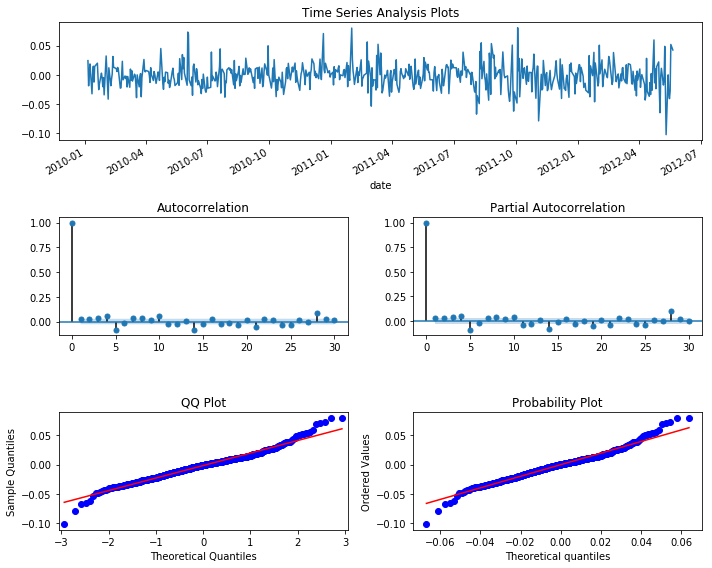

time: 1.13 s


In [7]:
plot.tsplot(price.boxcox);
regr.investigate(price.boxcox, verbose=True);

In [8]:
print(unitroot.ADF(price.boxcox).regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     113.5
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           6.39e-84
Time:                        17:36:03   Log-Likelihood:                 1446.6
No. Observations:                 595   AIC:                            -2881.
Df Residuals:                     589   BIC:                            -2855.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.9317      0.086    -10.797      0.0

#### Seasonality

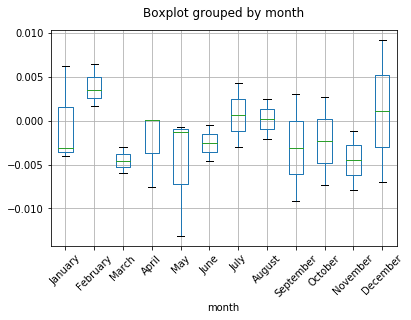

time: 581 ms


In [9]:
r = price.boxcox
monthly_returns = r.groupby([r.index.year.rename('year'), r.index.month.rename('month')]).mean()
monthly_returns = pd.DataFrame(monthly_returns.reset_index().values, columns=('year', 'month', 'return'))
ax = monthly_returns.boxplot(column='return', by='month')
ax.set_title('')
labels = [item.get_text() for item in ax.get_xticklabels()]
plt.xticks(monthly_returns.iloc[:12].month, [get_month(x) for x in monthly_returns.iloc[:12].month], rotation=45)
plt.tick_params(axis='both', which='major')

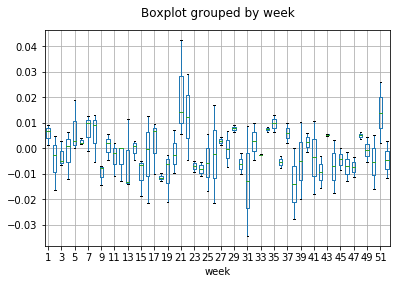

time: 1.14 s


In [10]:
r = price.boxcox
weekly_returns = r.groupby([r.index.year.rename('year'), r.index.week.rename('week')]).mean()
weekly_returns = pd.DataFrame(weekly_returns.reset_index().values, columns=('year', 'week', 'return'))
ax = weekly_returns.boxplot(column='return', by='week')
ax.set_title('')
labels = [item.get_text() for item in ax.get_xticklabels()]
plt.xticks(weekly_returns.iloc[:52:2].week, [int(x) for x in weekly_returns.iloc[:52:2].week])
plt.tick_params(axis='both', which='major')

There is no consistent shape over the years for weekdays

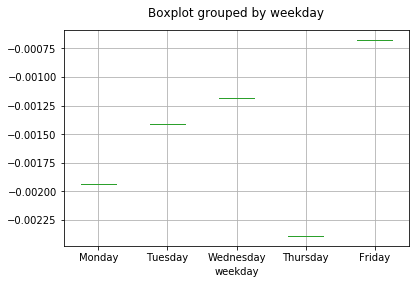

time: 379 ms


In [11]:
r = price.boxcox  # [price.boxcox.index.year == 2010]
daily_returns = r.groupby([r.index.weekday.rename('weekday')]).mean()
daily_returns = pd.DataFrame(daily_returns.reset_index().values, columns=('weekday', 'return'))
ax = daily_returns.boxplot(column='return', by='weekday')
ax.set_title('')
labels = [item.get_text() for item in ax.get_xticklabels()]
plt.xticks(daily_returns.iloc[:5].weekday + 1, [get_weekday(x) for x in daily_returns.iloc[:5].weekday])
plt.tick_params(axis='both', which='major')

In [12]:
a = smt.SARIMAX(price.boxcox, order=(3, 0, 2), seasonal_order=(0, 1, 1, 12))
f = a.fit(trend='nc', update_freq=5)

time: 6.68 s


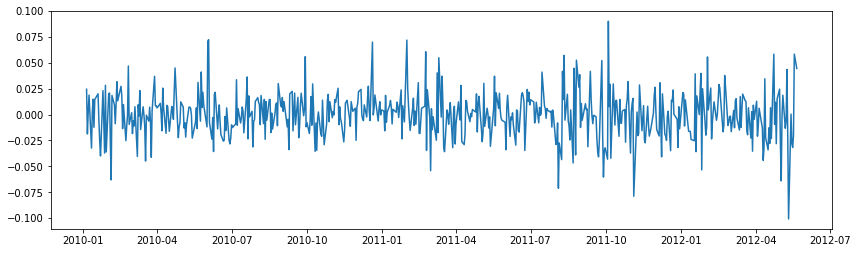

time: 364 ms


In [13]:
plt.subplots(figsize=(14, 4))
plt.plot(f.resid)

- https://medium.com/@a.nejad_99199/exploring-market-seasonality-trends-19a91381c0fe
- https://github.com/anejad/Exploring-Market-Seasonality-Trends/blob/master/Exploring%20Seasonality%20Trends%20in%20Stock%20Market.ipynb
- https://otexts.com/fpp2/components.html
- https://towardsdatascience.com/analysis-of-stock-market-cycles-with-fbprophet-package-in-python-7c36db32ecd0
- https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?article=2030&context=jmasm

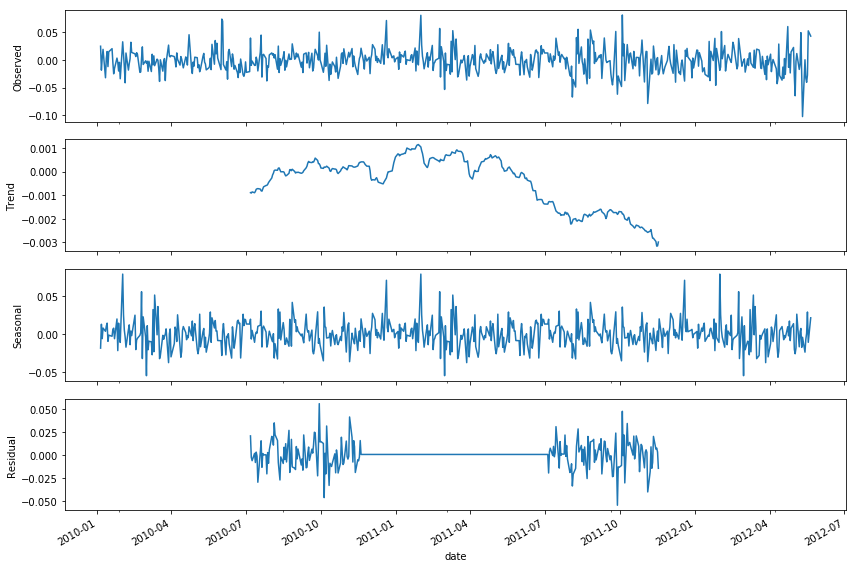

time: 810 ms


In [14]:
regr.inspect_seasonality(price.boxcox);

#### Develop & Fit ARIMA

In [ ]:
_, arima_params = regr.get_best_arima(price.boxcox)
model = smt.ARIMA(price.boxcox, order=arima_params)
model_fit = model.fit(method='mle', trend='nc', update_freq=5)
in_sample_predictions = model_fit.predict()

print(model_fit.summary())

In [ ]:
ex_sample_predictions = regr.predict_rolling_forward(price.boxcox, val_price.boxcox, arima_params)

In [ ]:
regr.is_autocorrelated(price.boxcox, verbose=True);
# After ARIMA modelling the autocorrelation is completely gone
regr.is_autocorrelated(model_fit.resid, verbose=True);

In [ ]:
regr.plot_arima_predictions(price.boxcox, val_price.boxcox, arima_params)

#### Develop & fit GARCH

In [ ]:
arima_residuals = regr.ARIMA_GARCH(price.boxcox, *arima_params, 1, 1).arima_fit.resid
_, garch_params = regr.get_best_garch(arima_residuals)
plot.tsplot(arima_residuals**2);

In [ ]:
# Result from last block: PACF is considerable until lag=5
garch_params = (5, 5) # p = lagged variance, q = lagged residuals
model = regr.ARIMA_GARCH(price.boxcox, *arima_params, *garch_params, vol_model='GARCH')
print(model.garch_fit.summary())

In [ ]:
ex_sample_predictions = regr.plot_garch_predictions(price.boxcox, val_price.boxcox, arima_params, garch_params, vol_model='GARCH')

### Correlate Industry-wise

#### Setup

In [7]:
def calc_residuals(industries=all_industries, norm_gspc=False):
    comps = np.concatenate([list(get_industry(x)) for x in industries]) 
    comp_symbols = [x[0] for x in comps]
    comp_chars = pd.DataFrame(
        index=comp_symbols, columns=[
        'arima_p', 'arima_d', 'arima_q', 'unit_root', 'autocorr', 'normal_dist', 'heteroscedastic', 'breaks'])
    comp_resid_chars = pd.DataFrame(comp_chars)
    comp_orig_prices = pd.DataFrame([x[2].open.rename(x[0]) for x in comps]).T
    if norm_gspc:
        comp_prices = pd.DataFrame([(x[2].boxcox - gspc.boxcox[x[2].index]).rename(x[0]) for x in comps], index=comp_symbols).T
    else:
        comp_prices = pd.DataFrame([(x[2].boxcox - ind_means[securities.get_industry(x[0])]).rename(x[0]) for x in comps], index=comp_symbols).T
    comp_resids = pd.DataFrame(index=comp_prices.index, columns=comp_symbols)
    
    # Apply ARIMA and take residuals
    for symbol, comp_name, _ in tqdm(comps):
        comp_price = comp_prices[symbol]
        _, arima_params = regr.get_best_arima(comp_price, p=range(5), q=range(3), verbose=False)
        model = smt.ARIMA(comp_price, order=arima_params)  # , exog=exog
        model_fit = model.fit(method='mle', trend='nc', update_freq=5)
        comp_resids.loc[:, symbol] = model_fit.resid
        comp_chars.loc[symbol] = (*arima_params, *regr.investigate(comp_price))
        comp_resid_chars.loc[symbol] = (*arima_params, *regr.investigate(model_fit.resid))
        time.sleep(1)
        
    
    print('Are the characteristics the same as before?', all(comp_resid_chars == comp_chars))
    
    return comp_symbols, comp_resids, comp_prices, comp_orig_prices, comp_resid_chars

def calc_correlations(comp_symbols, comp_prices):
    correlations = pd.DataFrame(np.nan, index=comp_symbols, columns=comp_symbols)
    for a, b in tqdm(itertools.product(comp_symbols, comp_symbols), total=len(comp_symbols)**2):
        if a <= b:
            continue
        correlations.loc[a, b] = math_utils.correlation(comp_prices.loc[:, a], comp_prices.loc[:, b])
        correlations.loc[b, a] = correlations.loc[a, b]
    return correlations

time: 171 ms


#### Correlations vs GSPC

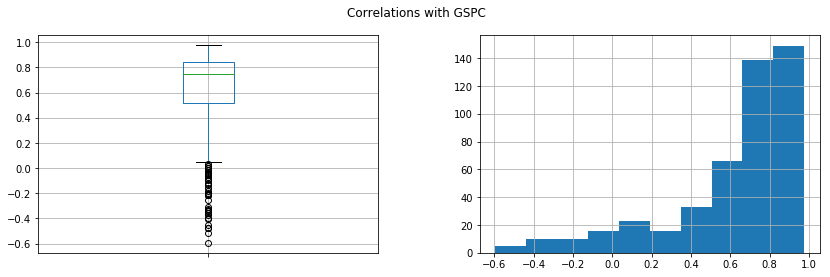

time: 977 ms


In [487]:
gspc_corrs = pd.DataFrame([math_utils.correlation(gspc.open[:len(x)], x.open)
                           for x in train_comp_prices], index=comp_metas.symbol, columns=[''])
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
gspc_corrs.boxplot(ax=axes[0])
gspc_corrs.hist(ax=axes[1])
fig.suptitle('Correlations with GSPC');

#### Correlation within Industry

In [11]:
ind_symbols, ind_resids, ind_prices, ind_orig_prices, ind_resid_chars = calc_residuals([industry_name])


Are the characteristics the same as before? True
time: 1min 46s


In [18]:
ind_resid_chars.head()

,arima_p,arima_d,arima_q,unit_root,autocorr,normal_dist,heteroscedastic,breaks
APA,4,0,1,0,0,0,1,0
APC,1,0,1,0,0,0,1,0
BHI,4,0,1,0,0,0,0,0
CHK,0,0,2,0,0,0,1,0
COG,4,0,2,0,0,0,0,0


time: 194 ms


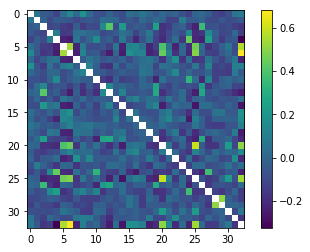

time: 874 ms


In [12]:
energy_correlations = calc_correlations(ind_symbols, ind_resids)
plt.imshow(energy_correlations)
plt.colorbar();

Correlate CVX and XOM:
Pearson's r = 0.68 (without preprocessing: 0.95)
Correlate COG and XOM:
Pearson's r = -0.32 (without preprocessing: 0.72)


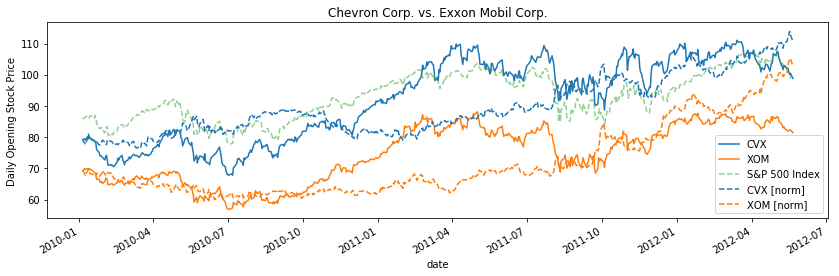

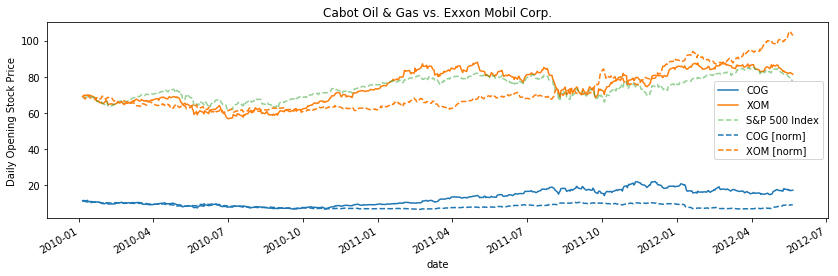

time: 1.39 s


In [497]:
stack = energy_correlations.stack()
pair = stack.idxmax()
# price_resids
plot.compare_industry_players(pair, energy_correlations.loc[pair], ind_prices, ind_orig_prices, gspc.open, securities)

pair = stack.idxmin()
plot.compare_industry_players(pair, energy_correlations.loc[pair], ind_prices, ind_orig_prices, gspc.open, securities)

Final correlation:  0.6922867603318198


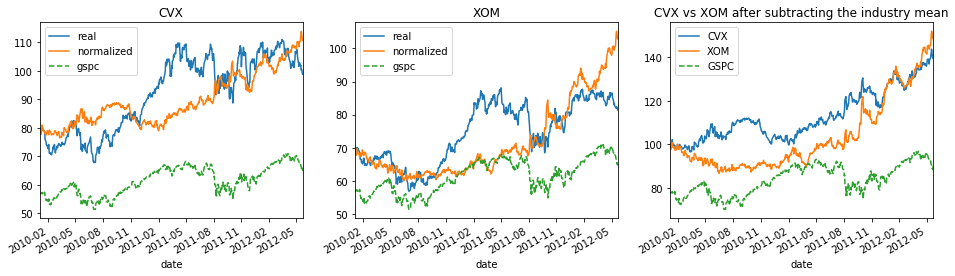

time: 1.34 s


In [499]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
a, b = stack.idxmax()
ind_orig_prices[a].plot(ax=axes[0], label='real', legend=True)
math_utils.abs_values(ind_prices[a], ind_orig_prices[a][0]).plot(ax=axes[0], label='normalized', legend=True, title=a)
(gspc.open / 20).plot(ls='--', ax=axes[0], label='gspc', legend=True)
axes[0].set_xlim((ind_prices[a].index[0], ind_prices[a].index[-1]))

ind_orig_prices[b].plot(ax=axes[1], label='real', legend=True)
math_utils.abs_values(ind_prices[b], ind_orig_prices[b][0]).plot(ax=axes[1], label='normalized', legend=True, title=b)
(gspc.open / 20).plot(ls='--', ax=axes[1], label='gspc', legend=True)
axes[1].set_xlim((ind_prices[b].index[0], ind_prices[b].index[-1]))

x = math_utils.abs_values(ind_prices[a])
y = math_utils.abs_values(ind_prices[b])
pd.concat([x, y], axis=1).plot(ax=axes[2], title=f'{a} vs {b} after subtracting the industry mean')
(gspc.open / gspc.open.max() * 100).plot(ls='--', ax=axes[2], label='GSPC', legend=True)
axes[2].set_xlim((x.index[0], x.index[-1]))
print('Final correlation: ', math_utils.correlation(*ind_prices.loc[:, stack.idxmax()].T.values))

#### Impact of Exogeneous Variables

Instead of subtracting the GSPC movement, one may consider GSPC (and industry mean) as exogeneous variables during the autoregression. The AR residuals (orange line) show that many GSPC movements almost vanished.

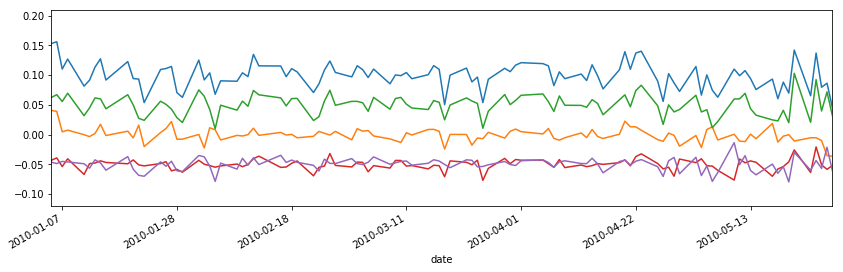

time: 519 ms


In [103]:
a, b = stack.idxmax()
ts = train_comp_prices[(comp_metas.symbol == a).idxmax()].boxcox  # industry_prices.loc[:, a]

mdl = smt.ARIMA(ts, exog=exog, order=(2, 0, 1)).fit(method='mle', trend='nc')

(ts + 0.1).plot(figsize=(14, 4))
plt.plot(mdl.resid)
plt.plot(mdl.fittedvalues + 0.05)
plt.plot(exog - 0.05)
plt.xlim((ts.index[0], ts.index[100]));

In [23]:
aic_values = regr.get_best_arima(ts, p=range(20), q=range(3, 4), exog=exog, debug=True)

Best AIC: -3844.2186 (worst: -3856.1580) | params: 19, 0, 3
time: 42min 20s


In [72]:
regr.investigate(mdl.resid, verbose=True);

Test for Unit Root:
>Augmented Dickey-Fuller (null = I(1)): p value = 0.0000
>KPSS (null = I(0)): p value = 0.7918
>Phillips-Perron (null = I(1)): p value = 0.0000

Test for Autocorrelation:
>Durbin-Watson (null(2) = no autocorr., lag 1): statistic = 1.8500
>Ljung-Box-Q (null = no autocorr., lag 1): p value = 0.09

Test for Normal Distribution:
>Jarque-Bera (null = gaussian): p value = 0.0000
>Shapiro-Wilk (null = gaussian): p value = 0.0000
>D’Agostino’s K^2 (null = gaussian): p value = 0.0000
>Anderson-Darling (null = gaussian): p value = 0.0000

Test for Heteroscedastiscity:
>Engle's ARCH (null = homosc.): p value = 0.0000

Test for Structural Breaks:
>CUSUM test on OLS residuals (null = stable coeff): p value = 0.9110
time: 310 ms


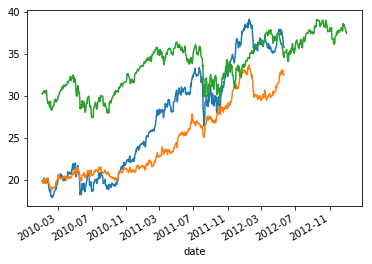

time: 487 ms


In [126]:
x.plot()
math_utils.abs_values(mdl.resid, x.iloc[0]).plot()
plt.plot(gspc.open / gspc.open.max() * x.max());

Outcome: I takes very long and the differences between the models are very small. So we keep the amount of coefficients low. Note that the significance is not present for less coeff.

#### Industry vs GSPC

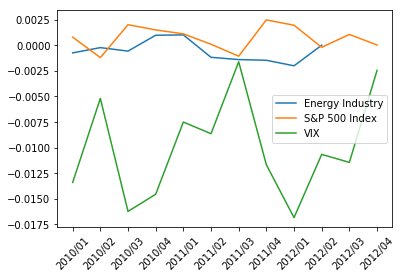

time: 502 ms


In [232]:
plot.plot_performance_quarterly(ind_prices, label='Energy Industry')
plot.plot_performance_quarterly(gspc.boxcox, label='S&P 500 Index')
plot.plot_performance_quarterly(vix.boxcox, label='VIX')
plt.legend();

### Graph

#### Setup

In [55]:
# https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py
# http://compbio.ucsd.edu/bringing-interactivity-network-visualization-jupyter-notebooks-visjs2jupyter/
def display_interactive_graph(G, output_file=None, pos=None, title='correlation', **kwargs):
    # Prepare graph data
    V = list(G.nodes())
    E = list(G.edges())
    weights = [x['weight'] for x in G.edges().values()]
    pos = (pos or nx.spring_layout)(G)

    V_enriched = [(x, securities.get_company_name(x), securities.get_industry(x), fundamentals.get_revenue(x)) for x in V]
    colors = plot.get_colors(np.unique([x[2] for x in V_enriched]))
    revenue_mean = np.nanmean([x[3] for x in V_enriched])
    revenue_max = np.nanmax([x[3] for x in V_enriched])

    nodes_dict = [{"id":n,
                   "title": f'{comp} ({industry})',
                   "color": colors[industry],
                   "border_width": 0.3,
                   "degree": ((revenue if not np.isnan(revenue) else revenue_mean) / revenue_max)**0.4,
                   "x":pos[n][0]*1000,
                   "y":pos[n][1]*1000} for (n, comp, industry, revenue) in V_enriched]
    node_map = dict(zip(V, range(len(V))))
    edges_dict = [{"id": f'{weights[i]:.2f}', "source": node_map[E[i][0]], "target": node_map[E[i][1]],
                   "width": 25 * weights[i]**2} for i in range(len(E))]
    return visJS_module.visjs_network(nodes_dict, edges_dict, graph_id=title, container=f'mynetwork{title}', node_icon_code="'undefined'",
                                      edge_width_field='width', edge_label_field='none', node_size_multiplier=25,
                                      graph_height=400, graph_width=800, export_network=bool(output_file), export_file=output_file, **kwargs)

def generate_graph(edges):
    edges = [(idx[0], idx[1], { 'weight': val }) for idx, val in edges.iteritems()]
    G = nx.Graph(title='number_of_shared_articles')
    G.add_weighted_edges_from([(x[0], x[1], x[2]['weight']) for x in edges])
    return G

def display_correlation_graph(correlations, pos=None, threshold=0.5, **kwargs):
    # Create and display grap
    edges = correlations.stack()
    edges = edges[edges >= threshold]
    G = generate_graph(edges)
    return display_interactive_graph(G, pos=pos, **kwargs)

time: 202 ms


#### Generate for one industry

In [ ]:
display_correlation_graph(energy_correlations)

#### Generate for multiple industries

In [13]:
comp_symbols, comp_resids, comp_prices, comp_orig_prices, comp_resid_chars = calc_residuals([all_industries[3], *all_industries[-2:]])


Are the characteristics the same as before? True
time: 5min 47s


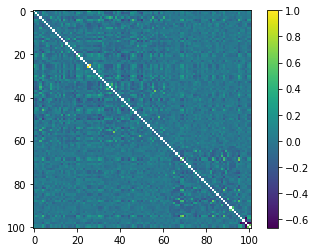

time: 4.2 s


In [29]:
correlations = calc_correlations(comp_symbols, comp_resids)
plt.imshow(correlations)
plt.colorbar();

In [60]:
# Layouts: https://networkx.github.io/documentation/networkx-2.2/reference/drawing.html
display_correlation_graph(correlations, pos=nx.circular_layout)

[{'id': '0.52', 'source': 0, 'target': 1, 'width': 6.632446583412458}, {'id': '1.00', 'source': 2, 'target': 3, 'width': 24.999999999077243}, {'id': '0.65', 'source': 4, 'target': 5, 'width': 10.701861467651131}, {'id': '0.52', 'source': 6, 'target': 7, 'width': 6.839320537570018}, {'id': '0.54', 'source': 8, 'target': 9, 'width': 7.312854363998021}, {'id': '0.56', 'source': 8, 'target': 10, 'width': 7.755832710483284}, {'id': '0.68', 'source': 9, 'target': 10, 'width': 11.584195883318062}, {'id': '0.51', 'source': 10, 'target': 11, 'width': 6.412673486621065}, {'id': '0.54', 'source': 10, 'target': 12, 'width': 7.256297076573672}, {'id': '0.60', 'source': 11, 'target': 12, 'width': 8.942396294510045}, {'id': '0.51', 'source': 13, 'target': 14, 'width': 6.580480145193668}, {'id': '0.63', 'source': 15, 'target': 16, 'width': 9.999872714502061}]


time: 281 ms


#### All Companies

In [ ]:
comp_symbols, comp_resids, comp_prices, comp_orig_prices, comp_resid_chars = calc_residuals(all_industries)

In [ ]:
correlations = calc_correlations(comp_symbols, comp_resids)

In [ ]:
correlations.stack().to_frame().boxplot()
correlations.stack().to_frame().hist()
print('Significance for Pearson\'s r:')
for p_value, pearson_r in math_utils.r_critical_values.iteritems():
    print(f'> {p_value}: {pearson_r}')

In [ ]:
display_correlation_graph(correlations, threshold=0.5)

### Correlate with Cooccurrence

In [377]:
coocs = pd.read_csv('../data/preprocessed/occurrences/cooccurrences.csv', index_col=0).astype(float)
coocs.values[(np.arange(coocs.shape[0]),)*2] = np.nan
coocs = coocs.stack().astype(float)

time: 243 ms


In [404]:
all_comps = np.concatenate([list(get_industry(x)) for x in all_industries])
all_comp_symbols = [x[0] for x in all_comps]
all_orig_prices = pd.DataFrame([x[2].open.rename(x[0]) for x in all_comps]).T
corrs_orig = calc_correlations(all_comp_symbols, all_orig_prices).stack().astype(float)

all_orig_prices2 = pd.DataFrame([x[2].boxcox.rename(x[0]) for x in all_comps]).T
corrs_boxcox = calc_correlations(all_comp_symbols, all_orig_prices2).stack().astype(float)

all_orig_prices3 = pd.DataFrame([(x[2].boxcox - gspc.boxcox[x[2].index]).rename(x[0]) for x in all_comps]).T
corrs_norm = calc_correlations(all_comp_symbols, all_orig_prices3).stack().astype(float)

all_orig_prices4 = pd.DataFrame([(x[2].boxcox - ind_means[securities.get_industry(x[0])]).rename(x[0]) for x in all_comps]).T
corrs_norm_ind = calc_correlations(all_comp_symbols, all_orig_prices4).stack().astype(float)

corrs_resid = correlations.stack().astype(float)

time: 1min 20s


In [458]:
merged = pd.concat([coocs.rename('cooc'),
                    corrs_orig.rename('corrs_orig'),
                    corrs_boxcox.rename('corrs_boxcox'),
                    corrs_norm.rename('corrs_norm_gspc'),
                    corrs_norm_ind.rename('corrs_norm_ind'),
                    corrs_resid.rename('corrs_resid')], axis=1).dropna()
merged.corr()

,cooc,corrs_orig,corrs_boxcox,corrs_norm_gspc,corrs_norm_ind,corrs_resid
cooc,1.000000,0.002661,0.058257,0.058714,0.067054,0.058572
corrs_orig,0.002661,1.000000,0.260428,0.247810,0.115234,0.250080
corrs_boxcox,0.058257,0.260428,1.000000,0.384397,0.194864,0.387011
corrs_norm_gspc,0.058714,0.247810,0.384397,1.000000,0.493081,0.999128
corrs_norm_ind,0.067054,0.115234,0.194864,0.493081,1.000000,0.492186
corrs_resid,0.058572,0.250080,0.387011,0.999128,0.492186,1.000000


time: 5.36 s


In [ ]:
# display_correlation_graph(corrs_orig.unstack(), threshold=0.9)
# display_correlation_graph(corrs_boxcox.unstack(), threshold=0.6)
# display_correlation_graph(corrs_norm.unstack(), threshold=0.5)
# display_correlation_graph(corrs_norm_ind.unstack(), threshold=0.5)
display_correlation_graph(corrs_resid.unstack(), threshold=0.5)

### TO READ

- https://shishirshakya.blogspot.com/2015/06/the-todayamamoto-approach-to-granger.html
- On Plotting https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

In [ ]:
def inspect_forecast(model_fit, train, val):
    # multi-step out-of-sample forecast
    start_index = len(train)
    end_index = start_index + len(val) - 1
    ex_sample_forecast = model_fit.predict(start=start_index, end=end_index)
    ex_sample_forecast.index = val.index

    in_sample_forecast = model_fit.predict(len(train)-101, len(train)-1)

    plt.plot(train.iloc[-100:])
    plt.plot(val, 'b--', alpha=0.2)
    plt.plot(in_sample_forecast, color='orange', alpha=0.2)
    plt.plot(ex_sample_forecast, color='orange')

inspect_forecast(model_fit, train, val)